In [65]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [66]:
geo = "GSE55993"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Leidinger2014", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [67]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]

In [68]:
table

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
VALUE,1.597713,2.866922,3.123045,1.276868,3.729534,6.461108,0.997509,0.514437,2.549119,4.883893,...,4.741841,4.780794,-0.631538,1.951530,10.341903,2.360723,4.437234,1.418332,3.546319,1.430139
VALUE,1.569786,2.978141,2.523807,1.058127,2.602819,6.313092,1.571382,1.239031,2.269577,4.552656,...,5.093919,5.373117,-0.139058,1.959635,10.425327,7.373143,4.532671,1.909580,3.035704,1.161776
VALUE,1.585265,2.134337,2.829239,1.267572,2.960690,1.817075,1.423240,0.462063,2.356895,4.485711,...,4.799167,5.423998,-0.097959,1.943231,10.782703,7.021439,3.791512,1.004798,3.387339,1.261971
VALUE,1.335035,2.157808,2.528000,1.330909,2.837385,2.801719,1.106735,0.564666,2.344618,3.982585,...,4.437234,5.018195,0.468434,2.184758,11.137706,8.180804,6.076414,1.232044,3.123045,1.267572
VALUE,1.516199,3.822315,2.523807,1.273586,2.093549,6.712629,0.908285,1.160335,2.304156,4.176986,...,5.071254,4.354178,-0.466601,1.992813,11.137706,2.187540,6.101862,1.673089,3.025737,1.498883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1.710729,2.292655,2.448641,1.576548,3.995802,2.423717,1.209793,1.032134,4.091648,4.234257,...,5.452155,7.573517,0.370489,1.965035,9.633589,2.202687,7.678173,1.329313,3.072030,1.304512
VALUE,2.001367,3.016536,2.157808,1.565966,3.982585,1.871807,1.784050,1.298543,4.372513,4.676862,...,5.265147,7.740316,0.218895,2.563974,9.716142,2.112242,7.516152,1.463067,2.739740,1.036653
VALUE,1.708829,2.190747,2.335906,1.675046,3.970601,2.323254,1.256097,0.804675,4.073547,4.636038,...,5.216658,7.573517,0.414457,2.086899,9.428025,1.975642,8.086553,1.379820,3.102057,0.957622
VALUE,1.345217,2.153358,2.101144,1.669377,4.676862,2.837385,1.145106,1.023439,4.331031,4.600858,...,3.970601,7.740316,0.345736,2.012465,9.337672,3.662305,7.573517,0.735301,3.714552,1.330909


### Get controls

In [69]:
list(data.gsms.values())[0].metadata

{'title': ['PAXGene blood lung cancer patient L2'],
 'geo_accession': ['GSM1349928'],
 'status': ['Public on Dec 31 2014'],
 'submission_date': ['Mar 18 2014'],
 'last_update_date': ['Dec 31 2014'],
 'type': ['RNA'],
 'channel_count': ['1'],
 'source_name_ch1': ['whole blood'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['disease state: Lung adenocarcinoma',
  'gender: female',
  'age: 77',
  'tissue: whole blood'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Total RNA including small RNAs was isolated using miRNeasy Micro Kit (Qiagen)  according to manufacturerâ€™s instructions.'],
 'label_ch1': ['Cy3'],
 'label_protocol_ch1': ['Total RNA samples were labelled using the Agilent miRNA Complete Labelling and Hybridisation Kit'],
 'hyb_protocol': ["Hybridisations were performed in Agilent SureHyb chambers for 20 hours at 55C and washed according to manufacturer's instructions."],
 'scan_protocol': ['Array-chips were scanned in a high

### Seperate case and controls

In [70]:
controls = np.array(["healthy" in k.metadata["title"][0] for k in list(data.gsms.values())])
sick = 1 - controls

In [71]:
sum(controls)

38

### Drop NAN

In [72]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_23564/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [73]:
X = table

In [74]:
X

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
VALUE,1.597713,2.866922,3.123045,1.276868,3.729534,6.461108,0.997509,0.514437,2.549119,4.883893,...,4.741841,4.780794,-0.631538,1.951530,10.341903,2.360723,4.437234,1.418332,3.546319,1.430139
VALUE,1.569786,2.978141,2.523807,1.058127,2.602819,6.313092,1.571382,1.239031,2.269577,4.552656,...,5.093919,5.373117,-0.139058,1.959635,10.425327,7.373143,4.532671,1.909580,3.035704,1.161776
VALUE,1.585265,2.134337,2.829239,1.267572,2.960690,1.817075,1.423240,0.462063,2.356895,4.485711,...,4.799167,5.423998,-0.097959,1.943231,10.782703,7.021439,3.791512,1.004798,3.387339,1.261971
VALUE,1.335035,2.157808,2.528000,1.330909,2.837385,2.801719,1.106735,0.564666,2.344618,3.982585,...,4.437234,5.018195,0.468434,2.184758,11.137706,8.180804,6.076414,1.232044,3.123045,1.267572
VALUE,1.516199,3.822315,2.523807,1.273586,2.093549,6.712629,0.908285,1.160335,2.304156,4.176986,...,5.071254,4.354178,-0.466601,1.992813,11.137706,2.187540,6.101862,1.673089,3.025737,1.498883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1.710729,2.292655,2.448641,1.576548,3.995802,2.423717,1.209793,1.032134,4.091648,4.234257,...,5.452155,7.573517,0.370489,1.965035,9.633589,2.202687,7.678173,1.329313,3.072030,1.304512
VALUE,2.001367,3.016536,2.157808,1.565966,3.982585,1.871807,1.784050,1.298543,4.372513,4.676862,...,5.265147,7.740316,0.218895,2.563974,9.716142,2.112242,7.516152,1.463067,2.739740,1.036653
VALUE,1.708829,2.190747,2.335906,1.675046,3.970601,2.323254,1.256097,0.804675,4.073547,4.636038,...,5.216658,7.573517,0.414457,2.086899,9.428025,1.975642,8.086553,1.379820,3.102057,0.957622
VALUE,1.345217,2.153358,2.101144,1.669377,4.676862,2.837385,1.145106,1.023439,4.331031,4.600858,...,3.970601,7.740316,0.345736,2.012465,9.337672,3.662305,7.573517,0.735301,3.714552,1.330909


In [75]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [76]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [77]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [78]:
mirnas.iloc[lowest], pvalues

(443       hsa-miR-34a
 452      hsa-miR-4266
 629     hsa-miR-16-1*
 246      hsa-miR-3923
 1068     hsa-miR-516b
 Name: ID_REF, dtype: object,
 array([0.00267255, 0.00318664, 0.01573092, 0.02160846, 0.02180893]))

### F-test

In [79]:
t3 = table

In [80]:
f, p = f_classif(t3, sick)

In [81]:
np.mean(p)

0.5715746257926745

### ANOVA

In [82]:
t3

,0,1,2,3,4,5,6,7,8,9,...,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204
VALUE,1.597713,2.866922,3.123045,1.276868,3.729534,6.461108,0.997509,0.514437,2.549119,4.883893,...,4.741841,4.780794,-0.631538,1.951530,10.341903,2.360723,4.437234,1.418332,3.546319,1.430139
VALUE,1.569786,2.978141,2.523807,1.058127,2.602819,6.313092,1.571382,1.239031,2.269577,4.552656,...,5.093919,5.373117,-0.139058,1.959635,10.425327,7.373143,4.532671,1.909580,3.035704,1.161776
VALUE,1.585265,2.134337,2.829239,1.267572,2.960690,1.817075,1.423240,0.462063,2.356895,4.485711,...,4.799167,5.423998,-0.097959,1.943231,10.782703,7.021439,3.791512,1.004798,3.387339,1.261971
VALUE,1.335035,2.157808,2.528000,1.330909,2.837385,2.801719,1.106735,0.564666,2.344618,3.982585,...,4.437234,5.018195,0.468434,2.184758,11.137706,8.180804,6.076414,1.232044,3.123045,1.267572
VALUE,1.516199,3.822315,2.523807,1.273586,2.093549,6.712629,0.908285,1.160335,2.304156,4.176986,...,5.071254,4.354178,-0.466601,1.992813,11.137706,2.187540,6.101862,1.673089,3.025737,1.498883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,1.710729,2.292655,2.448641,1.576548,3.995802,2.423717,1.209793,1.032134,4.091648,4.234257,...,5.452155,7.573517,0.370489,1.965035,9.633589,2.202687,7.678173,1.329313,3.072030,1.304512
VALUE,2.001367,3.016536,2.157808,1.565966,3.982585,1.871807,1.784050,1.298543,4.372513,4.676862,...,5.265147,7.740316,0.218895,2.563974,9.716142,2.112242,7.516152,1.463067,2.739740,1.036653
VALUE,1.708829,2.190747,2.335906,1.675046,3.970601,2.323254,1.256097,0.804675,4.073547,4.636038,...,5.216658,7.573517,0.414457,2.086899,9.428025,1.975642,8.086553,1.379820,3.102057,0.957622
VALUE,1.345217,2.153358,2.101144,1.669377,4.676862,2.837385,1.145106,1.023439,4.331031,4.600858,...,3.970601,7.740316,0.345736,2.012465,9.337672,3.662305,7.573517,0.735301,3.714552,1.330909


In [83]:
X = np.array(sick).reshape(-1, 1)

In [84]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [85]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.008590687635086703

### Mean-variance-plot

In [86]:
np.mean(table)

0       1.620307
1       2.418999
2       2.430841
3       1.614121
4       4.429612
          ...   
1200    3.229530
1201    7.548341
1202    1.420238
1203    3.303061
1204    1.220146
Length: 1205, dtype: float64

In [87]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [88]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

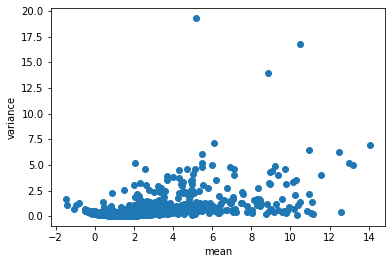

In [89]:
mean_variance_plot(table)

### Log transformation

In [90]:
log_table = table

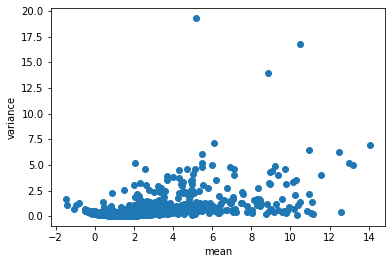

In [91]:
mean_variance_plot(log_table)

In [92]:
norm_log_table = log_table #- np.mean(log_table)

In [93]:
#norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

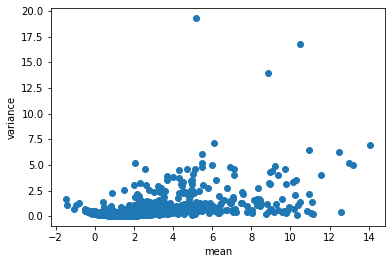

In [94]:
mean_variance_plot(norm_log_table)

### PCA

In [95]:
pca = decomposition.PCA(n_components=10)

In [96]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [97]:
pca.explained_variance_ratio_

array([0.38594343, 0.21948872, 0.07413855, 0.06310029, 0.03717908,
       0.02642878, 0.02312132, 0.01642091, 0.01120509, 0.01075345])

In [98]:
components = pca.transform(norm_log_table)

In [99]:
components.shape

(80, 10)

In [100]:
sum(controls)

38

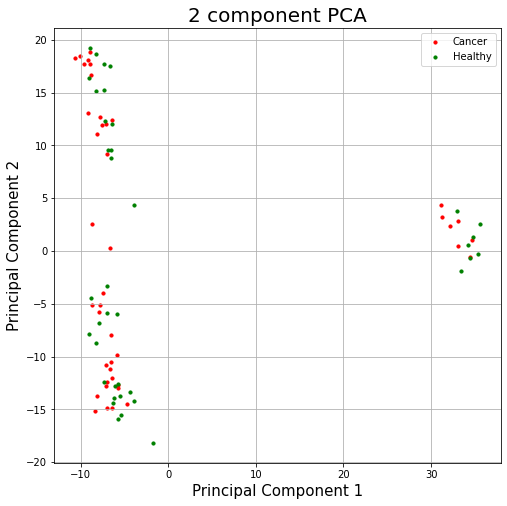

In [101]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [102]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

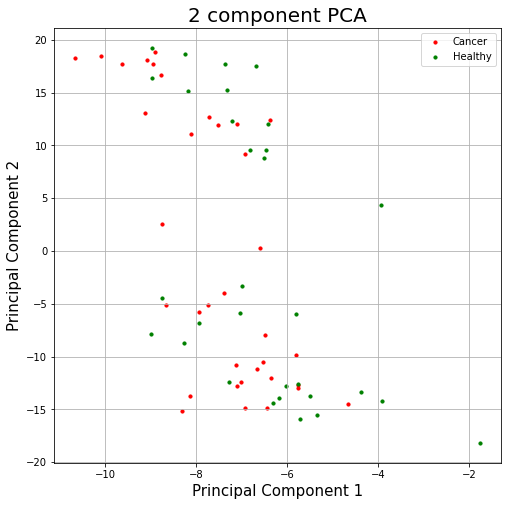

In [103]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [104]:
sex = np.array(["female" in k.metadata["characteristics_ch1"][1] for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])
age = np.array([float(k.metadata["characteristics_ch1"][2].split(" ")[1].replace("NA", "NaN")) for k in list(data.gsms.values()) if "post" not in k.metadata["characteristics_ch1"][0]])

In [105]:
covars = pd.DataFrame(np.array([sex, age]).transpose(), columns=["sex", "age"])

In [106]:
covars = covars.fillna(covars.mean())

In [107]:
covars

,sex,age
0,1.0,77.0
1,0.0,68.0
2,0.0,51.0
3,1.0,71.0
4,0.0,72.0
...,...,...
75,1.0,45.0
76,0.0,55.0
77,1.0,31.0
78,0.0,39.0


In [108]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [109]:
adj_norm_log_table = norm_log_table #- linreg.predict(covars)

# PCA

In [110]:
pca = decomposition.PCA(n_components=2)

In [111]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [112]:
components = pca.transform(adj_norm_log_table)

In [113]:
components

array([[ 33.0133013 ,   0.45737575],
       [ 34.44874328,  -0.56989233],
       [ 34.61764229,   1.05594808],
       [ 32.12710514,   2.33557838],
       [ 31.19302724,   3.1872517 ],
       [ 31.14181737,   4.32172562],
       [ 33.05829202,   2.82667141],
       [ 32.92790089,   3.79320612],
       [ 34.42630156,  -0.63611755],
       [ 35.37776711,  -0.27508281],
       [ 33.44222342,  -1.8538441 ],
       [ 34.79760103,   1.29675824],
       [ 34.15628767,   0.52942782],
       [ 35.62940464,   2.54785396],
       [ -7.11211684,  12.0030662 ],
       [ -6.93529737,   9.20359271],
       [ -8.1263083 ,  11.09110334],
       [ -7.72924127,  12.7131997 ],
       [ -9.12727117,  13.09632303],
       [ -6.38687594,  12.40796956],
       [ -7.51749258,  11.93019155],
       [ -7.20514339,  12.29647602],
       [ -3.94690151,   4.3901922 ],
       [ -6.81178956,   9.60175897],
       [ -6.50834514,   8.84686823],
       [ -6.46834913,   9.53951298],
       [ -6.42349609,  12.05764114],
 

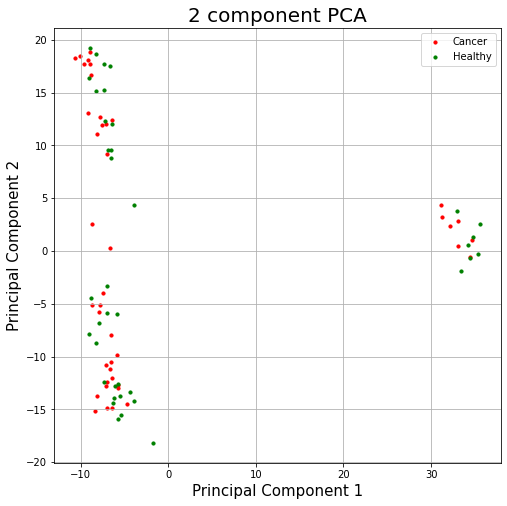

In [114]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [115]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [116]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


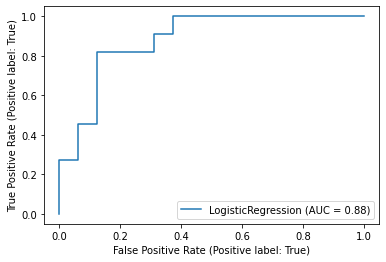

In [117]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [118]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[18:51:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


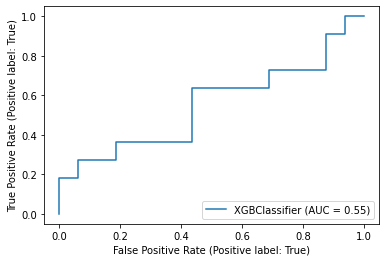

In [119]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [120]:
lookup_table = data.gpls["GPL16770"].table

In [121]:
lookup_table.head()

,ID,miRNA_ID,SPOT_ID
0,ebv-miR-BART1-3p,ebv-miR-BART1-3p,NaN
1,ebv-miR-BART1-5p,ebv-miR-BART1-5p,NaN
2,ebv-miR-BART10,ebv-miR-BART10,NaN
3,ebv-miR-BART10*,ebv-miR-BART10*,NaN
4,ebv-miR-BART11-3p,ebv-miR-BART11-3p,NaN


In [122]:
lookup_table = lookup_table.set_index("ID")

In [123]:
mirna_ids = lookup_table.loc[mirnas]["miRNA_ID"]

In [124]:
from Scripts import converters

In [125]:
sequences = converters.canonical_to_seq(mirnas, True)

In [126]:
sequences = np.array(sequences)
mirnas.loc[sequences == None]

46        hsa-miR-1274b
318       hsa-miR-1274a
715     hsa-miR-3647-3p
754         hsa-miR-720
952         hsa-let-7c*
1196       hsa-miR-1280
Name: ID_REF, dtype: object

In [127]:
mask = sequences != None
sequences = sequences[mask]
adj_norm_log_table = adj_norm_log_table.loc[:, mask]

In [128]:
adj_norm_log_table.columns = sequences
adj_norm_log_table = adj_norm_log_table.loc[:,~adj_norm_log_table.columns.duplicated()]
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,UUUUGCACCUUUUGGAGUGAA,AAAAGUAAUUGUGGUUUUUGCC,CCUCCUGCCCUCCUUGCUGU,UAAUACUGUCUGGUAAAACCGU,ACCGUGCAAAGGUAGCAUA,UCAGGCCAGGCACAGUGGCUCA,UCAGCACCAGGAUAUUGUUGGAG,AAGAUGUGGAAAAAUUGGAAUC,ACCAUCGACCGUUGAUUGUACC,CGUCAACACUUGCUGGUUUCCU,...,UCGCCUCCUCCUCUCCC,UCUACAAAGGAAAGCGCUUUCU,UCGUUUGCCUUUUUCUGCUU,AGCAGCAUUGUACAGGGCUAUGA,AACCCGUAGAUCCGAACUUGUG,UACAGUACUGUGAUAACUGAA,UGGAGUCCAGGAAUCUGCAUUUU,UGGACUGCCCUGAUCUGGAGA,UCAAAUGCUCAGACUCCUGUGGU,cancer
VALUE,1.597713,2.866922,3.123045,1.276868,3.729534,6.461108,0.997509,0.514437,2.549119,4.883893,...,4.741841,-0.631538,1.951530,10.341903,2.360723,4.437234,1.418332,3.546319,1.430139,1
VALUE,1.569786,2.978141,2.523807,1.058127,2.602819,6.313092,1.571382,1.239031,2.269577,4.552656,...,5.093919,-0.139058,1.959635,10.425327,7.373143,4.532671,1.909580,3.035704,1.161776,1
VALUE,1.585265,2.134337,2.829239,1.267572,2.960690,1.817075,1.423240,0.462063,2.356895,4.485711,...,4.799167,-0.097959,1.943231,10.782703,7.021439,3.791512,1.004798,3.387339,1.261971,1
VALUE,1.335035,2.157808,2.528000,1.330909,2.837385,2.801719,1.106735,0.564666,2.344618,3.982585,...,4.437234,0.468434,2.184758,11.137706,8.180804,6.076414,1.232044,3.123045,1.267572,1
VALUE,1.516199,3.822315,2.523807,1.273586,2.093549,6.712629,0.908285,1.160335,2.304156,4.176986,...,5.071254,-0.466601,1.992813,11.137706,2.187540,6.101862,1.673089,3.025737,1.498883,1


In [129]:
adj_norm_log_table.to_csv("../TransformedData/Leidinger2014_raw.csv", index=False)